In [17]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import applications

In [2]:
data = '/kaggle/input/medicineauthenticity'

In [3]:
train = list(os.walk(data))
label_names = train[0][1]
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
print(dict_labels)

{'neozep_authentic': 0, 'biogesic_counterfeit': 1, 'bioflu_counterfeit': 2, 'biogesic_authentic': 3, 'neozep_counterfeit': 4, 'bioflu_authentic': 5}


In [4]:
def dataset(path): #put path till the highest directory level
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):
        value_of_label = dict_labels[folder] #dict_labels is the dictionary whose key:value pairs are classes:numbers representing them

        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (150, 150))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels

images, labels = dataset(data)
images, labels = shuffle(images, labels)

100%|██████████| 6/6 [00:48<00:00,  8.05s/it]


In [5]:
images.shape

(256, 150, 150, 3)

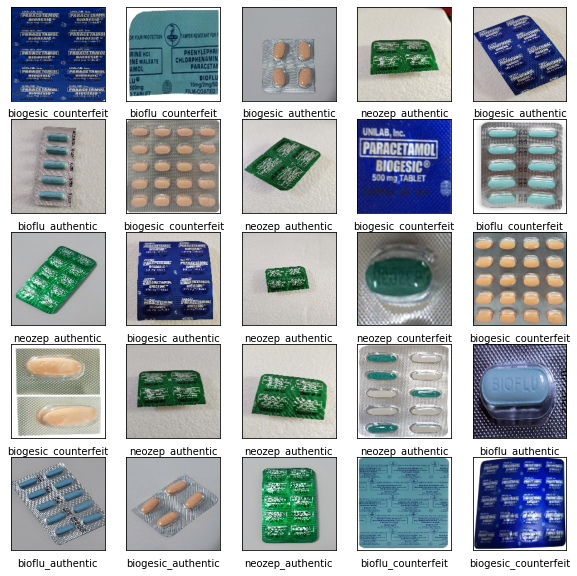

In [6]:
plt.figure(figsize = (10,10))
for _ in range(25):
    plt.subplot(5, 5, _+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    data = images[_]
    plt.xlabel(label_names[labels[_]])
    plt.imshow(data);

In [7]:
image_size = (224, 224)
batch_size = 64
train_datagen = ImageDataGenerator(rescale = 1./255,
                            shear_range = 0.4,
                            zoom_range = 0.4,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split = 0.2)

In [8]:
train_ds = train_datagen.flow_from_directory('/kaggle/input/medicineauthenticity',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'training',
                                      color_mode="rgb",)

val_ds = train_datagen.flow_from_directory('/kaggle/input/medicineauthenticity',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'validation',
                                      color_mode="rgb")

Found 208 images belonging to 6 classes.
Found 48 images belonging to 6 classes.


In [9]:
train_ds.class_indices

{'bioflu_authentic': 0,
 'bioflu_counterfeit': 1,
 'biogesic_authentic': 2,
 'biogesic_counterfeit': 3,
 'neozep_authentic': 4,
 'neozep_counterfeit': 5}

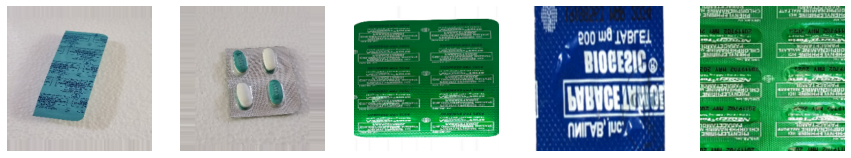

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

for i in range(5):
    image = next(train_ds)[0][0]
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis(False)

# VGG

In [11]:
vgg_base = applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
vgg_base.trainable = False

2022-12-29 15:47:08.966740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 15:47:09.061239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 15:47:09.062029: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 15:47:09.063332: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 3s 0us/step


In [12]:
inputs = Input(shape=(224, 224, 3))

x = vgg_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation = 'sigmoid')(x)
vgg_model = Model(inputs, outputs)
vgg_model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7fe6e4544fd0>>

In [13]:
vgg_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [14]:
epochs = 25
vgg_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

2022-12-29 15:47:30.759930: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


Epoch 1/25


2022-12-29 15:47:46.261682: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


4/4 [==============================] - 72s 16s/step - loss: 1.8313 - categorical_accuracy: 0.2548 - val_loss: 1.6405 - val_categorical_accuracy: 0.3750
Epoch 2/25
4/4 [==============================] - 53s 12s/step - loss: 1.5951 - categorical_accuracy: 0.3317 - val_loss: 1.5916 - val_categorical_accuracy: 0.3125
Epoch 3/25
4/4 [==============================] - 52s 16s/step - loss: 1.4357 - categorical_accuracy: 0.4567 - val_loss: 1.5248 - val_categorical_accuracy: 0.5208
Epoch 4/25
4/4 [==============================] - 54s 14s/step - loss: 1.3526 - categorical_accuracy: 0.5337 - val_loss: 1.3934 - val_categorical_accuracy: 0.4375
Epoch 5/25
4/4 [==============================] - 53s 17s/step - loss: 1.1683 - categorical_accuracy: 0.6106 - val_loss: 1.4163 - val_categorical_accuracy: 0.5000
Epoch 6/25
4/4 [==============================] - 52s 13s/step - loss: 1.1215 - categorical_accuracy: 0.6106 - val_loss: 1.2481 - val_categorical_accuracy: 0.5625
Epoch 7/25
4/4 [=================

In [15]:
vgg_model.save('vgg.hdf5') #this saves the model with the weights

Text(0.5, 1.0, 'Training and Validation Accuracy')

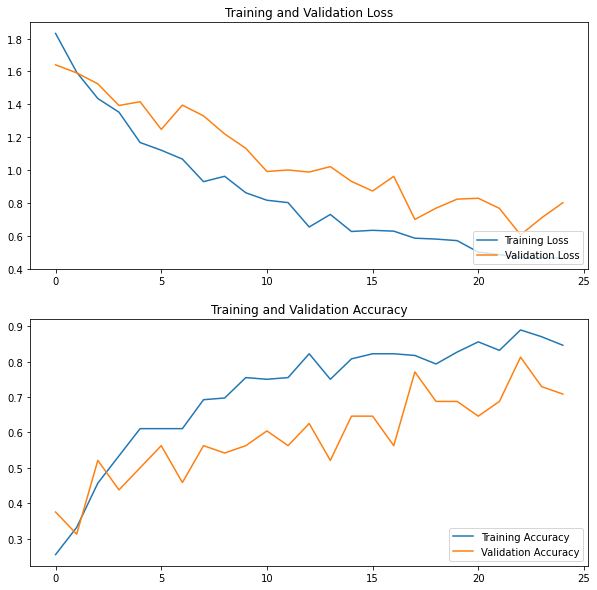

In [19]:
# Accuracy and Loss per epoch
df_result = pd.DataFrame(vgg_model.history.history)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(df_result[['loss']], label='Training Loss')
plt.plot(df_result[['val_loss']], label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(df_result[['categorical_accuracy']], label='Training Accuracy')
plt.plot(df_result[['val_categorical_accuracy']], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
     

In [25]:
loss, accuracy = vgg_model.evaluate(val_ds)

1/1 [==============================] - 8s 8s/step - loss: 0.8240 - categorical_accuracy: 0.7083


In [66]:
def predictor(img, model):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 224,224,3)
    
    label_names = train_ds.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    score = model.predict(image).max()*100
    print('Class: {0} \nPrediction: {1}'.format(clas, name))
    print('Score: ',str(round(score,2))+'%')

Class: 5 
Prediction: neozep_counterfeit
Score:  88.71%


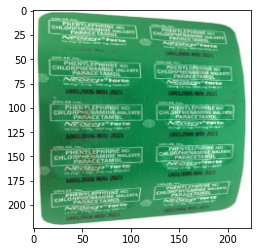

In [67]:
predictor('/kaggle/input/medicineauthenticity/neozep_counterfeit/image_114.png', vgg_model) 

# Xception

In [30]:
xcep_base = applications.Xception(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
xcep_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = xcep_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation = 'sigmoid')(x)
xcep_model = Model(inputs, outputs)

In [31]:
xcep_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [32]:
epochs = 25
xcep_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


4/4 [==============================] - 73s 17s/step - loss: 1.9333 - categorical_accuracy: 0.2163 - val_loss: 2.1232 - val_categorical_accuracy: 0.3333
Epoch 2/25
4/4 [==============================] - 56s 14s/step - loss: 1.4162 - categorical_accuracy: 0.5240 - val_loss: 1.2509 - val_categorical_accuracy: 0.4583
Epoch 3/25
4/4 [==============================] - 54s 14s/step - loss: 0.8031 - categorical_accuracy: 0.6683 - val_loss: 0.8891 - val_categorical_accuracy: 0.6458
Epoch 4/25
4/4 [==============================] - 52s 13s/step - loss: 0.7560 - categorical_accuracy: 0.7115 - val_loss: 0.8009 - val_categorical_accuracy: 0.6667
Epoch 5/25
4/4 [==============================] - 53s 17s/step - loss: 0.5376 - categorical_accuracy: 0.8173 - val_loss: 0.9230 - val_categorical_accuracy: 0.7083
Epoch 6/25
4/4 [==============================] - 53s 13s/step - loss: 0.4158 - categorical_accuracy: 0.8606 - val_loss: 0.7792 - val_categorical_accuracy: 0.7083
Epoch 7/25
4/4 [=================

In [33]:
xcep_model.save('xcep.hdf5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [49]:
xcep_model.history.history

{}

KeyError: "None of [Index(['loss'], dtype='object')] are in the [columns]"

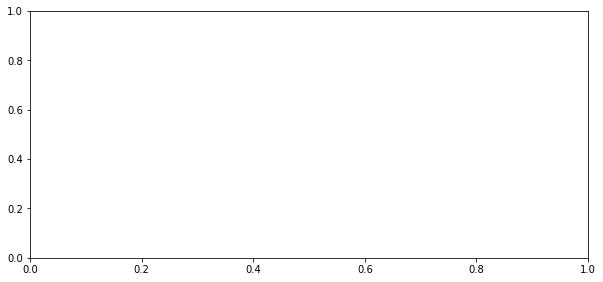

In [46]:
# Accuracy and Loss per epoch
df_result_xcep = pd.DataFrame(xcep_model.history.history)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(df_result_xcep[['loss']], label='Training Loss')
plt.plot(df_result_xcep[['val_loss']], label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(df_result_xcep[['categorical_accuracy']], label='Training Accuracy')
plt.plot(df_result_xcep[['val_categorical_accuracy']], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
     

In [44]:
loss, accuracy = xcep_model.evaluate(val_ds)

1/1 [==============================] - 8s 8s/step - loss: 0.5571 - categorical_accuracy: 0.7708


Class: 5 
Prediction: neozep_counterfeit
Score:  99.91%


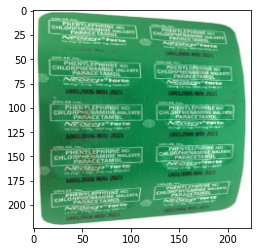

In [68]:
predictor('/kaggle/input/medicineauthenticity/neozep_counterfeit/image_114.png', xcep_model) 

# Inception V3

In [50]:
incep_base = applications.InceptionV3(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
incep_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = incep_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation = 'sigmoid')(x)
incep_model = Model(inputs, outputs)

87924736/87910968 [==============================] - 4s 0us/step


In [51]:
incep_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [52]:
epochs = 25
incep_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


4/4 [==============================] - 76s 18s/step - loss: 3.6933 - categorical_accuracy: 0.2500 - val_loss: 3.4112 - val_categorical_accuracy: 0.2708
Epoch 2/25
4/4 [==============================] - 54s 17s/step - loss: 2.9696 - categorical_accuracy: 0.4279 - val_loss: 2.1125 - val_categorical_accuracy: 0.3333
Epoch 3/25
4/4 [==============================] - 54s 14s/step - loss: 1.1513 - categorical_accuracy: 0.5721 - val_loss: 1.9492 - val_categorical_accuracy: 0.3333
Epoch 4/25
4/4 [==============================] - 55s 13s/step - loss: 1.2800 - categorical_accuracy: 0.5385 - val_loss: 1.1096 - val_categorical_accuracy: 0.5417
Epoch 5/25
4/4 [==============================] - 52s 16s/step - loss: 0.8118 - categorical_accuracy: 0.6875 - val_loss: 1.2423 - val_categorical_accuracy: 0.5417
Epoch 6/25
4/4 [==============================] - 54s 13s/step - loss: 0.6644 - categorical_accuracy: 0.7644 - val_loss: 1.0523 - val_categorical_accuracy: 0.6667
Epoch 7/25
4/4 [=================

Text(0.5, 1.0, 'Training and Validation Accuracy')

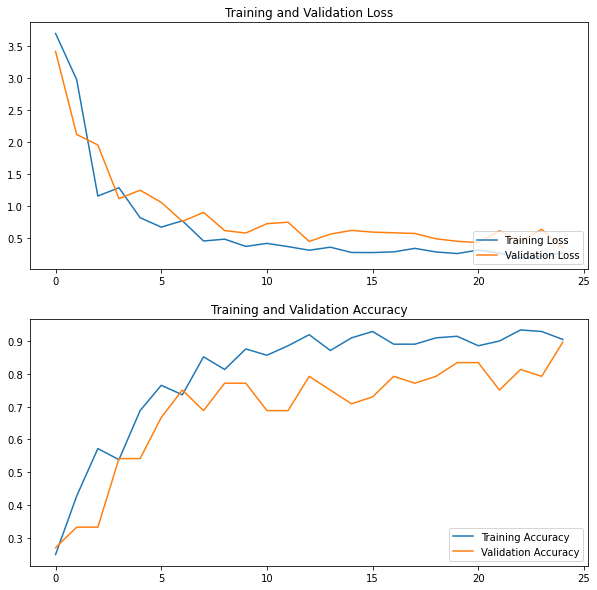

In [54]:
# Accuracy and Loss per epoch
df_result_incep = pd.DataFrame(incep_model.history.history)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(df_result_incep[['loss']], label='Training Loss')
plt.plot(df_result_incep[['val_loss']], label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(df_result_incep[['categorical_accuracy']], label='Training Accuracy')
plt.plot(df_result_incep[['val_categorical_accuracy']], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
     

In [55]:
loss, accuracy = incep_model.evaluate(val_ds)

1/1 [==============================] - 8s 8s/step - loss: 0.5067 - categorical_accuracy: 0.7917


Class: 5 
Prediction: neozep_counterfeit
Score:  98.57%


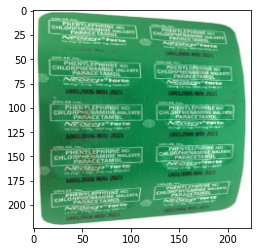

In [69]:
predictor('/kaggle/input/medicineauthenticity/neozep_counterfeit/image_114.png', incep_model) 

In [57]:
incep_model.save('incep.hdf5')